In [1]:
# Integration of endo cells using scvi-tools

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi

from matplotlib.pyplot import rc_context

Global seed set to 0
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
sc.settings.verbosity = 3
sc.set_figure_params(dpi=80, frameon=False, color_map='viridis_r', dpi_save=600)
palette_d = ['#378C4F', '#6DB6FFFF', '#F5CDCD', '#D9579B', '#A59ACB', '#7464AA', '#7BBC5E',  '#006DDBFF', '#B6DBFFFF', '#E2A7CC', '#924900FF']

In [3]:
adata_sc = scvi.data.read_h5ad('scRNA_endo.h5ad')

In [4]:
adata_sn = scvi.data.read_h5ad('snRNA_endo.h5ad')

In [5]:
adata = adata_sc.concatenate(adata_sn)

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [6]:
adata.obs

,patient_id,condition,sampletype,nCount_RNA,nFeature_RNA,mt_ratio,celltype,batch
PNT1_CCACCATGTAAGTCAA-1-0-0,scPNT1,adjancant normal,scRNA-seq,14303.0,3749,8.230849,Arterial EC,0
PNT1_ACAACCAGTTACGGAG-1-0-0,scPNT1,adjancant normal,scRNA-seq,12814.0,3360,4.722899,Venous EC,0
PNT1_TAGCACAGTTCCGCGA-1-0-0,scPNT1,adjancant normal,scRNA-seq,10716.0,3335,6.861034,Venous EC,0
PNT1_TTCATGTAGTGATAAC-1-0-0,scPNT1,adjancant normal,scRNA-seq,10114.0,3281,0.000000,Venous EC,0
PNT1_ACTATGGCAGCACAAG-1-0-0,scPNT1,adjancant normal,scRNA-seq,8896.0,2481,5.845993,Venous EC,0
...,...,...,...,...,...,...,...,...
RT3_TCTGGCTCAGATTAAG-1-1-1,snRT3,tumor,snRNA-seq,1679.0,1169,0.390190,unknown,1
RT3_ACTGCAACAAGAAATC-1-1-1,snRT3,tumor,snRNA-seq,1677.0,1117,6.204584,unknown,1
RT3_CAAGACTAGACGACTG-1-1-1,snRT3,tumor,snRNA-seq,1711.0,1148,0.652174,unknown,1
RT3_GTTACCCGTGGATGAC-1-1-1,snRT3,tumor,snRNA-seq,1554.0,1068,2.726146,unknown,1


In [7]:
adata.layers['counts'] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


In [8]:
# select HVGs
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="sampletype",
    subset=True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [13]:
adata.obs.patient_id.value_counts()

patient_id
scPT3     1235
scPT5      596
scPT4      589
scRT3      564
scPT2      537
snRT3      461
snRT1      440
snRT2      360
scPNT3     312
scPNT2     284
snPNT2     261
snPT4      152
scRT2      114
snPT5      114
snPT2       99
scPT1       90
snPT6       81
scRT1       68
scPNT4      65
snPT9       64
snPNT1      36
snPT8       15
snPT1       13
scPNT1       7
snPT7        2
snPT3        1
Name: count, dtype: int64

In [17]:
adata = adata[~adata.obs.patient_id.isin(["snPT3", "snPT7", "scPNT1"])]

In [20]:
adata = adata.copy()

In [21]:
adata# setup anndata
scvi.model.SCVI.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=["sampletype", "patient_id"],
    continuous_covariate_keys=["mt_ratio"]
)

In [22]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood='nb')

In [23]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████████████████████████████████████| 400/400 [02:29<00:00,  2.84it/s, loss=1.04e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████| 400/400 [02:29<00:00,  2.68it/s, loss=1.04e+03, v_num=1]


In [24]:
# get latent representation 
adata.obsm['X_scvi'] = vae.get_latent_representation()
adata.layers['scvi_normalized'] = vae.get_normalized_expression(library_size=10e4)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


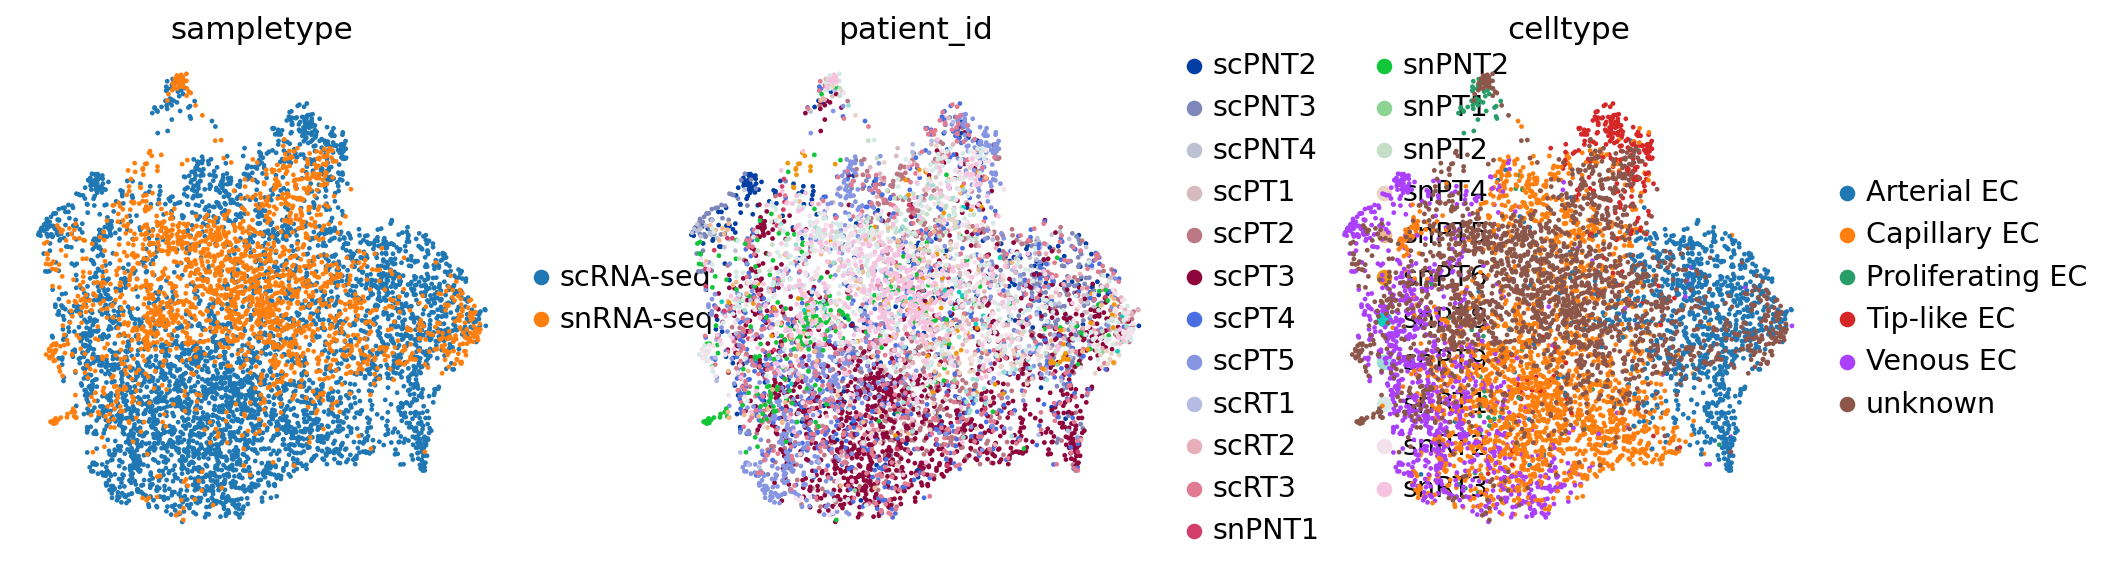

In [25]:
# use the corrected cell embeddings from scvi
sc.pp.neighbors(adata, use_rep='X_scvi')
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["sampletype", "patient_id", "celltype"],
    frameon=False
)

In [26]:
# intergration using scANVI
np.unique(adata.obs["celltype"], return_counts = True)

(array(['Arterial EC', 'Capillary EC', 'Proliferating EC', 'Tip-like EC',
        'Venous EC', 'unknown'], dtype=object),
 array([1019, 2022,   85,  268, 1060, 2096]))

In [29]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    unlabeled_category="unknown",
    labels_key="celltype",
)

In [30]:
lvae.train(max_epochs=25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25/25: 100%|██████████████████████████████████████████████| 25/25 [00:19<00:00,  1.32it/s, loss=1.05e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████████████████████████████████████████| 25/25 [00:19<00:00,  1.30it/s, loss=1.05e+03, v_num=1]


In [31]:
# predict labels in snRNA-seq, and get the latent space
adata.obs["C_scANVI"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)
adata.layers['scanvi_normalized'] = lvae.get_normalized_expression(library_size=10e4)

In [32]:
# use the corrected cell embeddings from scanvi
# the label prediction from scanvi seem to be raletively goo# 
sc.pp.neighbors(adata, use_rep='X_scANVI')
sc.tl.umap(adata, min_dist=0.2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [33]:
sc.tl.leiden(adata, resolution=0.8, key_added="scanvi_leiden")

running Leiden clustering
    finished: found 14 clusters and added
    'scanvi_leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


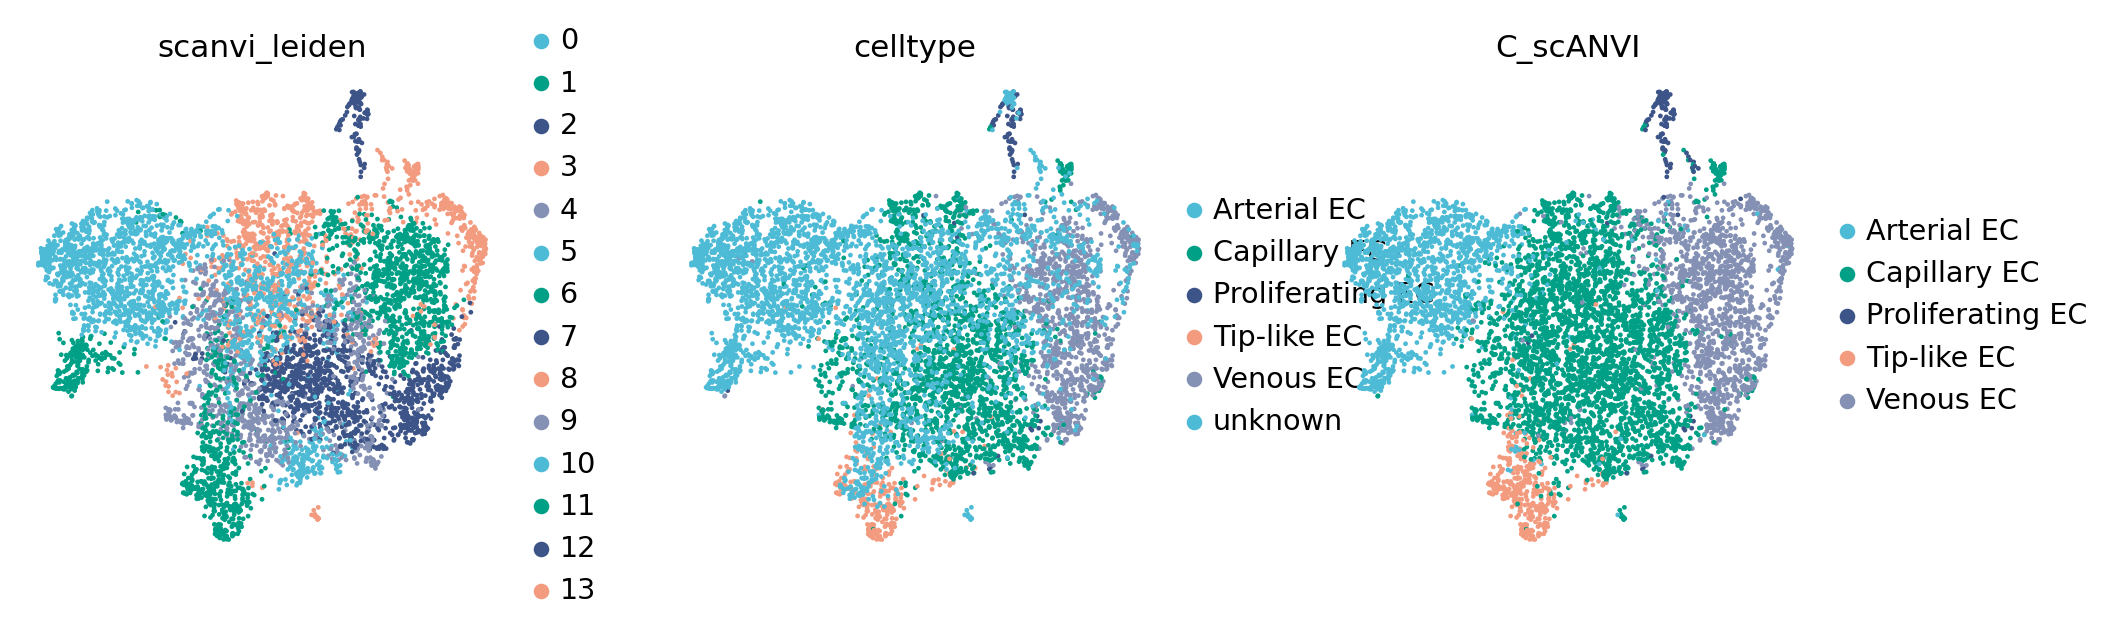

In [50]:
sc.pl.umap(adata, color=['scanvi_leiden', "celltype", "C_scANVI"])

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


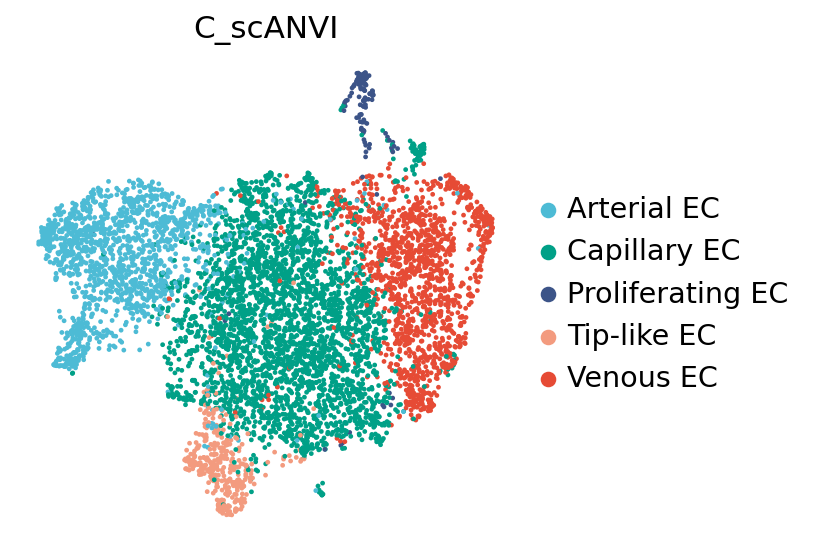

In [53]:
sc.pl.umap(adata, color = "C_scANVI", palette=["#4DBBD5", "#00A087", "#3C5488", "#F39B7F", "#E64B35"], save="EC_landscape.pdf")

In [36]:
adata.obs["celltype_scanvi"] = adata.obs.C_scANVI.copy()

In [37]:
adata.write("adata_EC_integrated.h5ad")

In [3]:
adata = sc.read_h5ad("adata_EC_integrated.h5ad")

In [12]:
markers = {"Arterial EC": ["GJA5", "FBLN5"], 
           "Capillary EC": ["PLVAP", "EDNRB"], 
           "Proliferating EC": ["MKI67", "TOP2A"], 
           "Tip-like EC": ["ESM1", "ANGPT2"], 
           "Venous EC": ["ACKR1", "SELP"]}

/opt/miniconda3/envs/scverse/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


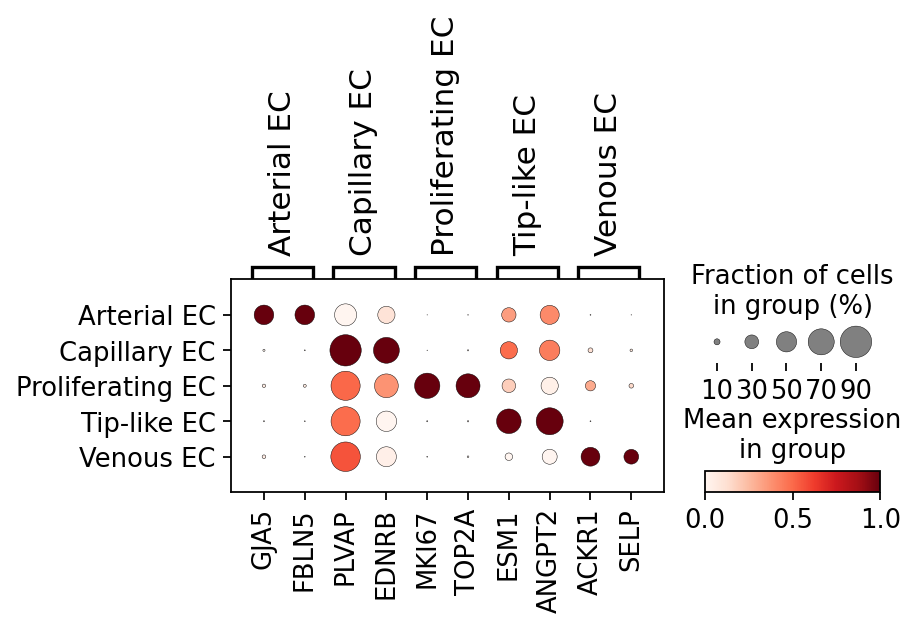

In [14]:
sc.pl.dotplot(adata, markers, "celltype_scanvi", standard_scale="var", save="CAF_markers_dotplot.pdf")

In [38]:
import anndata as ad

In [39]:
adata_raw = ad.concat([adata_sc, adata_sn])

In [40]:
adata_raw

AnnData object with n_obs × n_vars = 6560 × 16294
    obs: 'patient_id', 'condition', 'sampletype', 'nCount_RNA', 'nFeature_RNA', 'mt_ratio', 'celltype'
    obsm: 'X_harmony', 'X_pca', 'X_scanvi', 'X_scvi', 'X_umap'

In [42]:
adata_raw = adata_raw[~adata_raw.obs.patient_id.isin(["snPT3", "snPT7", "scPNT1"])]

In [44]:
adata_raw.obs = adata.obs.copy()

In [45]:
adata_raw.obs

,patient_id,condition,sampletype,nCount_RNA,nFeature_RNA,mt_ratio,celltype,batch,_scvi_batch,_scvi_labels,C_scANVI,scanvi_leiden,celltype_scanvi
PNT2_CCGGACAAGCACAAAT-1-0-0,scPNT2,adjancant normal,scRNA-seq,39389.0,6230,4.738311,Venous EC,0,0,4,Venous EC,8,Venous EC
PNT2_ATATCCTTCTACCCAC-1-0-0,scPNT2,adjancant normal,scRNA-seq,34961.0,6595,2.448676,Venous EC,0,0,4,Venous EC,8,Venous EC
PNT2_AAAGAACTCTGCGAGC-1-0-0,scPNT2,adjancant normal,scRNA-seq,32138.0,5809,5.124481,Venous EC,0,0,4,Venous EC,8,Venous EC
PNT2_GAAGCCCTCCTACCGT-1-0-0,scPNT2,adjancant normal,scRNA-seq,29262.0,6087,2.343395,Venous EC,0,0,4,Venous EC,8,Venous EC
PNT2_ATCTTCAGTAGTACGG-1-0-0,scPNT2,adjancant normal,scRNA-seq,28890.0,5243,3.825707,Venous EC,0,0,4,Venous EC,8,Venous EC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RT3_TCTGGCTCAGATTAAG-1-1-1,snRT3,tumor,snRNA-seq,1679.0,1169,0.390190,unknown,1,0,5,Arterial EC,9,Arterial EC
RT3_ACTGCAACAAGAAATC-1-1-1,snRT3,tumor,snRNA-seq,1677.0,1117,6.204584,unknown,1,0,5,Capillary EC,5,Capillary EC
RT3_CAAGACTAGACGACTG-1-1-1,snRT3,tumor,snRNA-seq,1711.0,1148,0.652174,unknown,1,0,5,Capillary EC,9,Capillary EC
RT3_GTTACCCGTGGATGAC-1-1-1,snRT3,tumor,snRNA-seq,1554.0,1068,2.726146,unknown,1,0,5,Arterial EC,5,Arterial EC


In [46]:
adata_raw.write("adata_EC_raw.h5ad")